In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.8e}'.format

import configparser
from collections import defaultdict
from src.character import Character, CharacterType 
from src.stats import random_stats
from src.selection import stochastic_tournament_selection, deterministic_tournament_selection, add_relative_accumulate, elitist_selection, roulette_wheel_selection, universal_selection, boltzmann_selection, rank_based_selection
from src.genes import  encode_genes, decode_genes
from src.mutation import one_gene_mutation, multi_gene_mutation, multi_gene_mutation_uniform

In [2]:
import sys
sys.path.append("src")

from src.population import generate_init_population, eval_performace
from src.crossover import single_point_crossover, two_point_crossover, uniform_crossover, annular_crossover, normalize_chromosome


In [3]:
def read_config(filename):
    config = configparser.ConfigParser()
    config.read(filename)
    params = defaultdict(dict)
    for section in config.sections():
        for key, value in config.items(section):
            params[section][key] = value
    return params

#params = read_config('config_file.config')


In [4]:
from collections import namedtuple

def parameters():
    
    config_params = read_config('config_file.config')

    # Personaje 
    type = eval(config_params['CHARACTER']['type'])
    
    # sum( stats ) = 150
    maxStatsValue = eval(config_params['M']['m'])
    
    # N
    populationNumber = eval(config_params['N']['n'])
    # K
    k = eval(config_params['K']['k'])

    # Numero máximo de generaciones - criterio de corte
    numberOfGenerations = eval(config_params['GENERATIONS']['number'])
    
    # A%
    method1Percentage = eval(config_params['METHOD1PERCENTAGE']['percentage'])
    selectionMethod1 = eval(config_params['SELECTION_METHOD']['method1'])
    selectionMethod2 = eval(config_params['SELECTION_METHOD']['method2'])
   
    # CrossOver
    metodo_cruza = eval(config_params['metodo_cruza']['crossover'])
 
    # Mutation
    mutation_type = eval(config_params['MUTATION']['mutation_type'])
    mutation_rate = eval(config_params['MUTATION']['mutation_rate'])

    # B%
    methodReplacePercentage = eval(config_params['METHODRePERCENTAGE']['percentage'])
    metodo_reemplazo3 = eval(config_params['metodo_reemplazo']['metodo1'])
    metodo_reemplazo4 = eval(config_params['metodo_reemplazo']['metodo2'])

    cutCriteria = eval(config_params['CUT_CRITERIA']['criteria_type'])
    
    # Selector parameters
    # M
    tournament_size = eval(config_params['deterministic_tournament_selection']['tournament_size'])
    # stochastic_tournament_selection
    threhold = eval(config_params['stochastic_tournament_selection']['threshold'])
    # Boltzmann parameters
    boltzmannT_0 = eval(config_params['BOLTZMANN']['t_0'])
    boltzmannT_c = eval(config_params['BOLTZMANN']['t_offset'])
    boltzmannM = eval(config_params['BOLTZMANN']['m'])

    Param = namedtuple('Param',[
        'character',
        'maxStatsValue',
        'populationNumber',
        'k',
        'numberOfGenerations',
        'method1Percentage',
        'selectionMethod1',
        'selectionMethod2',
        'metodo_cruza',
        'mutation_type',
        'mutation_rate',
        'methodReplacePercentage',
        'metodo_reemplazo3',
        'metodo_reemplazo4',
        'cutCriteria',
        'tournament_size',
        'threhold',
        'boltzmannT_0',
        'boltzmannT_c',
        'boltzmannM'
    ])    

    parametros = Param(
                character=type,
                maxStatsValue=maxStatsValue,
                populationNumber=populationNumber,
                k=k,
                numberOfGenerations=numberOfGenerations,
                method1Percentage=method1Percentage,
                selectionMethod1=selectionMethod1,
                selectionMethod2=selectionMethod2,
                metodo_cruza=metodo_cruza,
                mutation_type=mutation_type,
                mutation_rate=mutation_rate,
                methodReplacePercentage=methodReplacePercentage,
                metodo_reemplazo3=metodo_reemplazo3,
                metodo_reemplazo4=metodo_reemplazo4,
                cutCriteria=cutCriteria,
                tournament_size=tournament_size,
                threhold=threhold,
                boltzmannT_0=boltzmannT_0,
                boltzmannT_c=boltzmannT_c,
                boltzmannM=boltzmannM
    )

    return parametros

#p = parameters()


In [5]:
"""
from src.character import Character, CharacterType 
import sys
sys.path.append("src")

from src.population import generate_init_population

#GENERACION 0

generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)
generacion = 0
"""


'\nfrom src.character import Character, CharacterType \nimport sys\nsys.path.append("src")\n\nfrom src.population import generate_init_population\n\n#GENERACION 0\n\ngeneration_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)\ngeneracion = 0\n'

In [6]:
"""
# GUARDO EL MAS APTO DE LA GENERACION 0
# Escribe la poblacion inicial.
#generation_0.insert(0, 'generation', int(generacion))
generation_0['generation'] = generacion
mas_apto_G0 = generation_0.head(1)
mas_apto_G0.to_csv(f'datos-Prueba1.csv', mode='w', index=False)
"""


"\n# GUARDO EL MAS APTO DE LA GENERACION 0\n# Escribe la poblacion inicial.\n#generation_0.insert(0, 'generation', int(generacion))\ngeneration_0['generation'] = generacion\nmas_apto_G0 = generation_0.head(1)\nmas_apto_G0.to_csv(f'datos-Prueba1.csv', mode='w', index=False)\n"

In [7]:

def method_selector(Kt, method1Percentage): 
    # Selecciono K individuos
    # Utilizo el porcentaje para cada método
    K1 = int(np.round(Kt * method1Percentage))
    K2 = Kt - K1
    return K1, K2

#k1, k2 = method_selector(p.k, p.method1Percentage)

In [8]:
#current_generation = generation_0
#generacion = 0

In [9]:
def selection_method(poblacion, ki, params, method, generation):
    
    #print(f' Generacion: {generation}')
    poblacion_rel_acu = add_relative_accumulate(poblacion)

    if(method == 'elitist'):
        selected = elitist_selection(poblacion_rel_acu, ki)
    elif(method == 'roulette_wheel'):
        selected = roulette_wheel_selection(poblacion_rel_acu, ki)
    elif(method == 'boltzmann'):
        selected = boltzmann_selection(poblacion_rel_acu, ki, generation, params.boltzmannT_0,params.boltzmannT_c,params.boltzmannM)
        #print(newPopulationRoulette)
    elif(method == 'universal_selection'):
        selected = universal_selection(poblacion_rel_acu, ki)
        #print(newPopulationRoulette)
    elif(method == 'deterministic_tournament'):
        selected = deterministic_tournament_selection(poblacion_rel_acu, params.tournament_size, ki)
        #print(newPopulationRoulette)
    elif(method == 'stochastic_tournament'):
        selected = stochastic_tournament_selection(poblacion_rel_acu, ki, params.threhold)
        #print(newPopulationRoulette)
    elif(method == 'rank_based'):
        selected = rank_based_selection(poblacion_rel_acu, ki)
        #print(newPopulationRoulette)
    return selected
"""
# SELECCION DE PADRES
generacion_sel1 = selection_method(current_generation, k1, p, p.selectionMethod1, generacion)
generacion_sel2 = selection_method(current_generation, k2, p, p.selectionMethod2, generacion)

# SELECCION TOTAL: K padres
selection_total = pd.concat([generacion_sel1, generacion_sel2])

selection_total.drop(columns=['performance_relative'], inplace=True)
selection_total.drop(columns=['performance_accumulated'], inplace=True)
selection_total = selection_total.sort_values(by='performance', ascending=False)
selection_total.reset_index(drop=True, inplace=True)
"""


"\n# SELECCION DE PADRES\ngeneracion_sel1 = selection_method(current_generation, k1, p, p.selectionMethod1, generacion)\ngeneracion_sel2 = selection_method(current_generation, k2, p, p.selectionMethod2, generacion)\n\n# SELECCION TOTAL: K padres\nselection_total = pd.concat([generacion_sel1, generacion_sel2])\n\nselection_total.drop(columns=['performance_relative'], inplace=True)\nselection_total.drop(columns=['performance_accumulated'], inplace=True)\nselection_total = selection_total.sort_values(by='performance', ascending=False)\nselection_total.reset_index(drop=True, inplace=True)\n"

In [10]:
#cromosomas = encode_genes(selection_total)

#cromosomas

In [11]:
def crossover_method(poblacion, method):
    
    if(method == 'one_point'):
        crossed = single_point_crossover(poblacion)
    elif(method == 'two_point'):
        crossed = two_point_crossover(poblacion)
    elif(method == 'uniform'):
        crossed = uniform_crossover(poblacion)
    elif(method == 'annular'):
        crossed = annular_crossover(poblacion)
    
    return crossed

#crossed_result = crossover_method(cromosomas, p.metodo_cruza)

#crossed_result

In [12]:
def mutation_method(poblacion, rate, method):
    
    if(method == 'one_gene'):
        mutated = one_gene_mutation(poblacion, rate)
    elif(method == 'multi_gene'):
        mutated = multi_gene_mutation(poblacion, rate)
    elif(method == 'multi_gene_mutation_uniform'):
        mutated = multi_gene_mutation_uniform(poblacion, rate)
    
    return mutated

#mutation_result = mutation_method(crossed_result, p.mutation_rate, p.mutation_type)

#mutation_result

In [13]:
#cromosomas_norm = normalize_chromosome(mutation_result)

#cromosomas_norm

In [14]:
"""
cromosomas_norm_decode = decode_genes(cromosomas_norm)
offspring = eval_performace(cromosomas_norm_decode,p.character)

offspring = offspring.sort_values(by='performance', ascending=False)
offspring.reset_index(drop=True, inplace=True)

offspring

"""

"\ncromosomas_norm_decode = decode_genes(cromosomas_norm)\noffspring = eval_performace(cromosomas_norm_decode,p.character)\n\noffspring = offspring.sort_values(by='performance', ascending=False)\noffspring.reset_index(drop=True, inplace=True)\n\noffspring\n\n"

In [15]:
"""
# REEMPLAZO
# padres:  selection_total de tamaño K
# hijos: offspring  de tamaño K
# tomo K de los hijos
k_reemplazo_metodo3 = p.k
# el resto para completar N
k_reemplazo_metodo4 = p.populationNumber - p.k

# SELECCION DE PADRES
generacion_reemp1 = selection_method(offspring, k_reemplazo_metodo3, p, p.metodo_reemplazo3, generacion)
generacion_reemp2 = selection_method(selection_total, k_reemplazo_metodo4, p, p.metodo_reemplazo4, generacion)

# SELECCION TOTAL: K padres
new_generation = pd.concat([generacion_reemp1, generacion_reemp2])

new_generation.drop(columns=['performance_relative'], inplace=True)
new_generation.drop(columns=['performance_accumulated'], inplace=True)
new_generation = new_generation.sort_values(by='performance', ascending=False)
new_generation.reset_index(drop=True, inplace=True)

new_generation
"""

"\n# REEMPLAZO\n# padres:  selection_total de tamaño K\n# hijos: offspring  de tamaño K\n# tomo K de los hijos\nk_reemplazo_metodo3 = p.k\n# el resto para completar N\nk_reemplazo_metodo4 = p.populationNumber - p.k\n\n# SELECCION DE PADRES\ngeneracion_reemp1 = selection_method(offspring, k_reemplazo_metodo3, p, p.metodo_reemplazo3, generacion)\ngeneracion_reemp2 = selection_method(selection_total, k_reemplazo_metodo4, p, p.metodo_reemplazo4, generacion)\n\n# SELECCION TOTAL: K padres\nnew_generation = pd.concat([generacion_reemp1, generacion_reemp2])\n\nnew_generation.drop(columns=['performance_relative'], inplace=True)\nnew_generation.drop(columns=['performance_accumulated'], inplace=True)\nnew_generation = new_generation.sort_values(by='performance', ascending=False)\nnew_generation.reset_index(drop=True, inplace=True)\n\nnew_generation\n"

In [16]:
"""
generacion += 1
# GUARDO EL MAS APTO DE LA GENERACION NUEVA
# Escribe la poblacion inicial.

#new_generation.insert(0, 'generation', int(generacion))
new_generation['generation'] = generacion
mas_apto_NG = new_generation.head(1)
mas_apto_NG.to_csv(f'datos-Prueba1.csv', mode='a', header=False, index=False)
"""

"\ngeneracion += 1\n# GUARDO EL MAS APTO DE LA GENERACION NUEVA\n# Escribe la poblacion inicial.\n\n#new_generation.insert(0, 'generation', int(generacion))\nnew_generation['generation'] = generacion\nmas_apto_NG = new_generation.head(1)\nmas_apto_NG.to_csv(f'datos-Prueba1.csv', mode='a', header=False, index=False)\n"

In [17]:
# Lectura de parametros
params = read_config('config_file.config')
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
max_generations = p.numberOfGenerations
print(f'max_generations = {p.numberOfGenerations}')

# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)
generacion = 0

# GUARDO EL MAS APTO DE LA GENERACION 0
# Escribe la poblacion inicial.
generation_0['generation'] = generacion
mas_apto_G0 = generation_0.head(1)
mas_apto_G0.to_csv(f'datos-Prueba1.csv', mode='w', index=False)

#MOTOR AG START!
while(generacion < max_generations):
    # SELECCION DE PADRES
    k1, k2 = method_selector(p.k, p.method1Percentage)
    current_generation = generation_0

    generacion_sel1 = selection_method(current_generation, k1, p, p.selectionMethod1, generacion)
    generacion_sel2 = selection_method(current_generation, k2, p, p.selectionMethod2, generacion)

    # SELECCION TOTAL: K padres
    selection_total = pd.concat([generacion_sel1, generacion_sel2])

    selection_total.drop(columns=['performance_relative'], inplace=True)
    selection_total.drop(columns=['performance_accumulated'], inplace=True)
    selection_total = selection_total.sort_values(by='performance', ascending=False)
    selection_total.reset_index(drop=True, inplace=True)

    # CROSSOVER
    cromosomas = encode_genes(selection_total)
    crossed_result = crossover_method(cromosomas, p.metodo_cruza)
    #print(f'tamanio cross: {len(crossed_result)}')

    # MUTACION
    mutation_result = mutation_method(crossed_result, p.mutation_rate, p.mutation_type)
    cromosomas_norm = normalize_chromosome(mutation_result)
    #print(f'tamanio mutacion: {len(mutation_result)}')
    #print(f'tamanio normalizaion: {len(cromosomas_norm)}')

    # Decodifico los valores de los stats
    cromosomas_norm_decode = decode_genes(cromosomas_norm)
    #print(f'tamanio normalizaion decode: {len(cromosomas_norm_decode)}')

    # Calculo el PERFORMANCE
    offspring = eval_performace(cromosomas_norm_decode,p.character)

    offspring = offspring.sort_values(by='performance', ascending=False)
    offspring.reset_index(drop=True, inplace=True)
    # OFFSPRING son los hijos

    #print(f'tamanio padre = {len(selection_total)}')
    #print(f'tamanio hijos = {len(offspring)}')

    # REEMPLAZO
    # CRITERIO DE REEMPLAZO
    # padres:  selection_total de tamaño K
    # hijos: offspring  de tamaño K
    # tomo K de los hijos
    k_reemplazo_metodo3 = p.k
    # el resto para completar N
    k_reemplazo_metodo4 = p.populationNumber - p.k

    #print(f'k_reemplazo_metodo3 (k) = {k_reemplazo_metodo3}')
    #print(f'k_reemplazo_metodo4 (N - k)= {k_reemplazo_metodo4}')

    # REEMPLAZO DE INDIVIDUOS
    generacion_reemp1 = selection_method(offspring, k_reemplazo_metodo3, p, p.metodo_reemplazo3, generacion)
    generacion_reemp2 = selection_method(selection_total, k_reemplazo_metodo4, p, p.metodo_reemplazo4, generacion)
    #print(f'k_reemplazo_metodo3 (k) = {len(generacion_reemp1)}')
    #print(f'k_reemplazo_metodo4 (N - k)= {len(generacion_reemp2)}')

    # INDIVIDUOS TOTAL
    new_generation = pd.concat([generacion_reemp1, generacion_reemp2])

    new_generation.drop(columns=['performance_relative'], inplace=True)
    new_generation.drop(columns=['performance_accumulated'], inplace=True)
    new_generation = new_generation.sort_values(by='performance', ascending=False)
    new_generation.reset_index(drop=True, inplace=True)

    generacion += 1
    # GUARDO EL MAS APTO DE LA GENERACION NUEVA

    new_generation['generation'] = generacion
    mas_apto_NG = new_generation.head(1)
    mas_apto_NG.to_csv(f'datos-Prueba1.csv', mode='a', header=False, index=False)

#new_generation

N = 100
K = 60
max_generations = 300


,strength,agility,expertise,resistance,life,height,characterType,performance,generation
0,1.90000000e+01,8.00000000e+00,2.20000000e+01,5.00000000e+00,6.00000000e+00,1.90000000e+00,CharacterType.ARCHER,1.45105372e+02,300
1,1.60000000e+01,8.00000000e+00,2.60000000e+01,2.00000000e+00,8.00000000e+00,1.90000000e+00,CharacterType.ARCHER,1.43122411e+02,300
2,1.60000000e+01,8.00000000e+00,2.60000000e+01,2.00000000e+00,8.00000000e+00,1.90000000e+00,CharacterType.ARCHER,1.43122411e+02,300
3,1.60000000e+01,8.00000000e+00,2.60000000e+01,2.00000000e+00,8.00000000e+00,1.90000000e+00,CharacterType.ARCHER,1.43122411e+02,300
4,1.60000000e+01,8.00000000e+00,2.60000000e+01,2.00000000e+00,8.00000000e+00,1.90000000e+00,CharacterType.ARCHER,1.43122411e+02,300
...,...,...,...,...,...,...,...,...,...
95,2.20000000e+01,6.00000000e+01,5.60000000e+01,8.00000000e+00,1.00000000e+00,1.60000000e+00,CharacterType.ARCHER,2.33333333e-01,300
96,2.20000000e+01,6.00000000e+01,5.60000000e+01,8.00000000e+00,1.00000000e+00,1.60000000e+00,CharacterType.ARCHER,2.33333333e-01,300
97,2.20000000e+01,6.00000000e+01,5.60000000e+01,8.00000000e+00,1.00000000e+00,1.60000000e+00,CharacterType.ARCHER,2.33333333e-01,300
98,3.30000000e+01,5.40000000e+01,3.30000000e+01,2.60000000e+01,2.00000000e+00,1.80000000e+00,CharacterType.ARCHER,2.16666667e-01,300


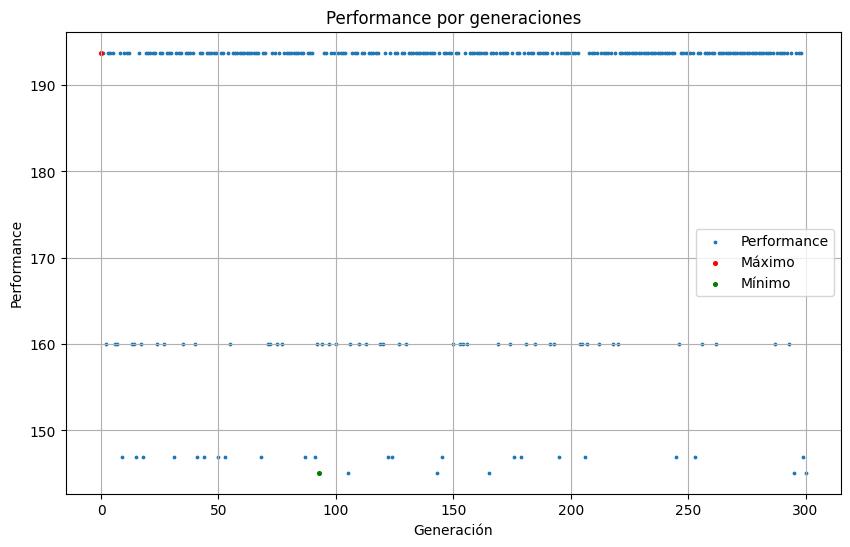

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
df = pd.read_csv("datos-Prueba1.csv")

# Encontrar el valor máximo y mínimo de la columna 'performance'
max_performance = df['performance'].max()
min_performance = df['performance'].min()

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(df['generation'], df['performance'], label='Performance', s=3)
plt.scatter(df['generation'].iloc[df['performance'].idxmax()], max_performance, color='red', label='Máximo', s=7)
plt.scatter(df['generation'].iloc[df['performance'].idxmin()], min_performance, color='green', label='Mínimo', s=7)
plt.xlabel('Generación')
plt.ylabel('Performance')
plt.title('Performance por generaciones')
plt.legend()
plt.grid(True)
plt.show()